In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import os

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [8, 6]
from metavision_core.event_io import RawReader

### Load recordings from the dataset


In [3]:
dir_path = ["uvled_freq_dataset", "recordings"]
dir_path = os.path.join(*dir_path)

lables_2_5k = ["0.5 m @ 2.5kHz", "1 m @ 2.5kHz", "1.5 m @ 2.5kHz", "2 m @ 2.5kHz", "2.5 m @ 2.5kHz"]
lables_5k =   ["0.5 m @ 5kHz", "1 m @ 5kHz", "1.5 m @ 5kHz", "2 m @ 5kHz", "2.5 m @ 5kHz"]

recordings_2_5k = [
	["2.5k", "0_5", "0", "recording_2024-10-02_11-20-10.raw"],
	["2.5k", "1",   "0", "recording_2024-10-02_11-19-19.raw"],
	["2.5k", "1_5", "0", "recording_2024-10-02_11-14-51.raw"],
	["2.5k", "2",   "0", "recording_2024-10-02_11-13-56.raw"],
	["2.5k", "2_5", "0", "recording_2024-10-02_11-11-28.raw"]
]

recordings_5k = [
	["5k", "0_5", "0", "recording_2024-10-02_10-26-52.raw"],
	["5k", "1",   "0", "recording_2024-10-02_10-30-16.raw"],
	["5k", "1_5", "0", "recording_2024-10-02_10-31-29.raw"],
	["5k", "2",   "0", "recording_2024-10-02_11-06-24.raw"],
	["5k", "2_5", "0", "recording_2024-10-02_11-09-53.raw"]
]

recordings_2_5k = list(map(lambda x: os.path.join(dir_path, *x), recordings_2_5k))
recordings_5k = list(map(lambda x: os.path.join(dir_path, *x), recordings_5k))

raws_2_5k = [RawReader(r) for r in recordings_2_5k]
raws_5k = [RawReader(r) for r in recordings_5k]

### Visualize the data to be sure

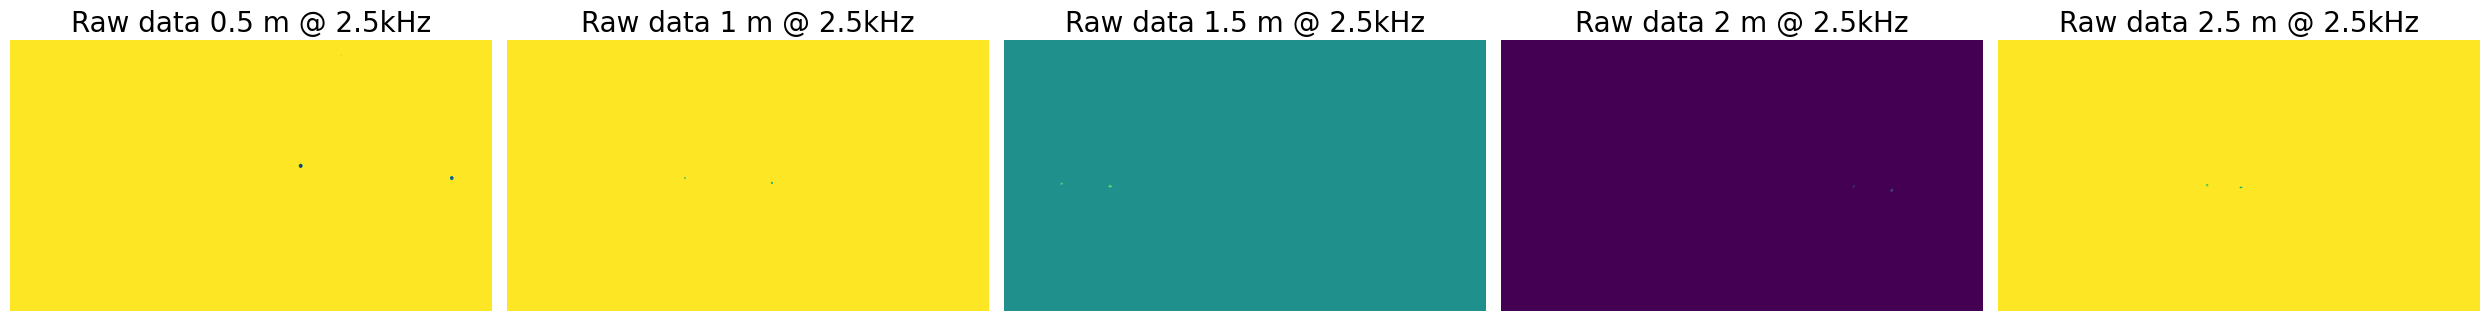

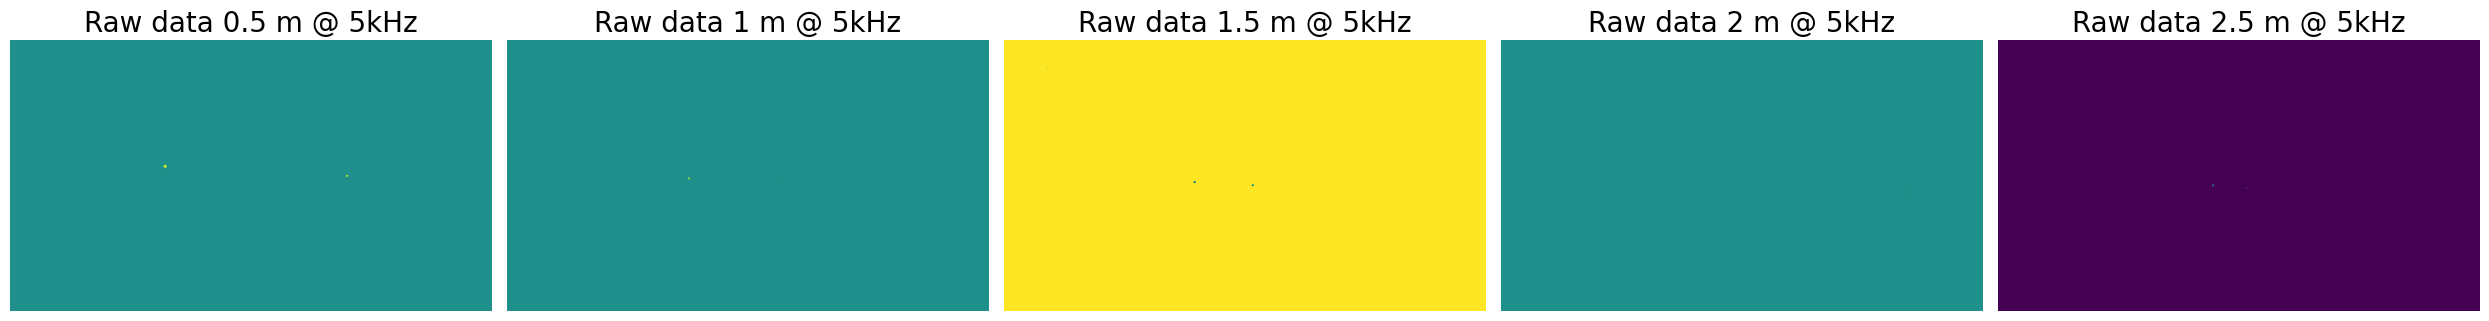

In [4]:
from plotting import visualize_data_raws

visualize_data_raws(raws_2_5k, lables_2_5k)

visualize_data_raws(raws_5k, lables_5k)

### Locate the UV LEDs in the data

In [41]:
from util import find_bounding_boxes

#run multiple times if error gets raised here
try:
	bb_2_5k = [find_bounding_boxes(r)[0][0] for r in raws_2_5k]
	bb_5k =   [find_bounding_boxes(r)[0][0] for r in raws_5k]

except Exception as e:
	print("Try running this again.")
	raise(e)

print(bb_2_5k)
print(bb_5k)

[(761.0, 325.0, 781.0, 345.0), (461.0, 357.0, 481.0, 377.0), (143.0, 372.0, 163.0, 392.0), (926.0, 380.0, 946.0, 400.0), (544.0, 377.0, 564.0, 397.0)]
[(401.0, 326.0, 421.0, 346.0), (472.0, 358.0, 492.0, 378.0), (496.0, 368.0, 516.0, 388.0), (973.0, 384.0, 993.0, 404.0), (560.0, 376.0, 580.0, 396.0)]


### Visualize the bounding boxes in the data

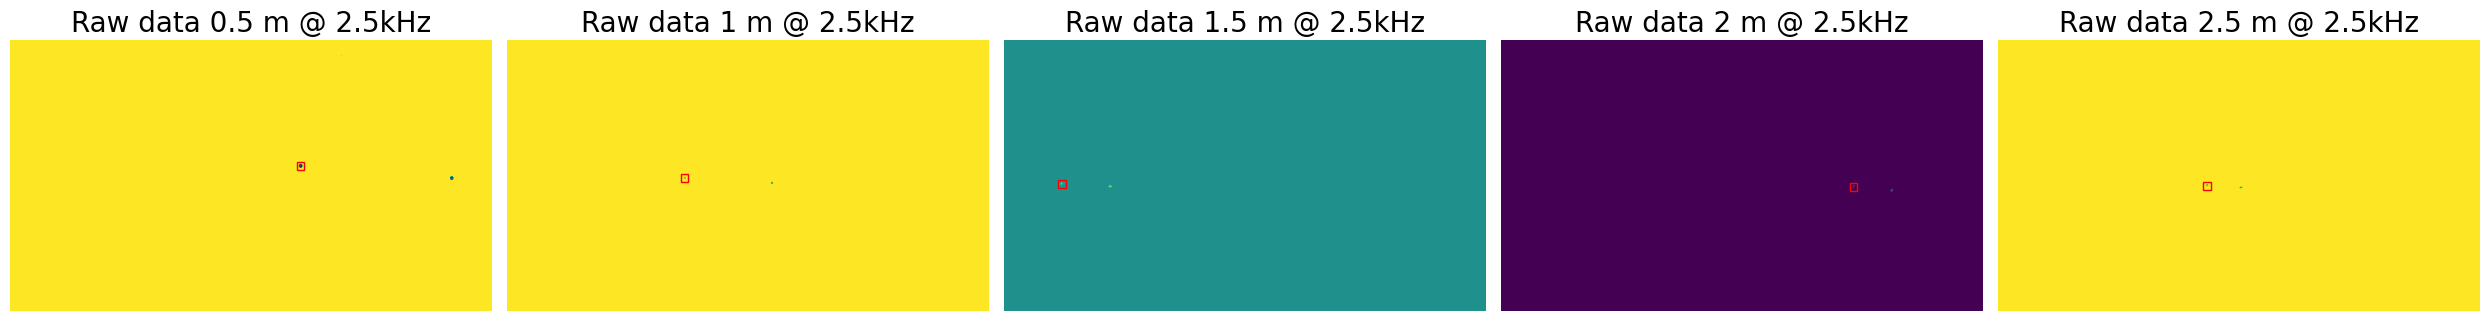

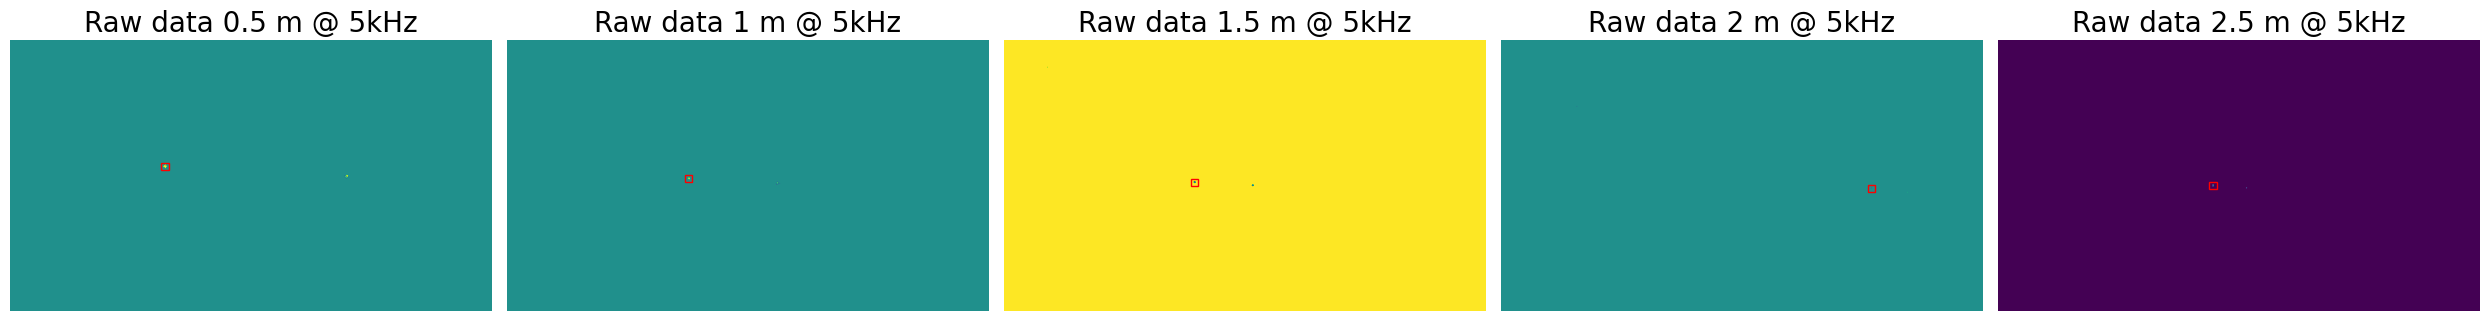

In [42]:
visualize_data_raws(raws_2_5k, lables_2_5k, boxes=bb_2_5k)
visualize_data_raws(raws_5k, lables_5k, boxes=bb_5k)

### Filter only the important events that are located inside of the bounding boxes

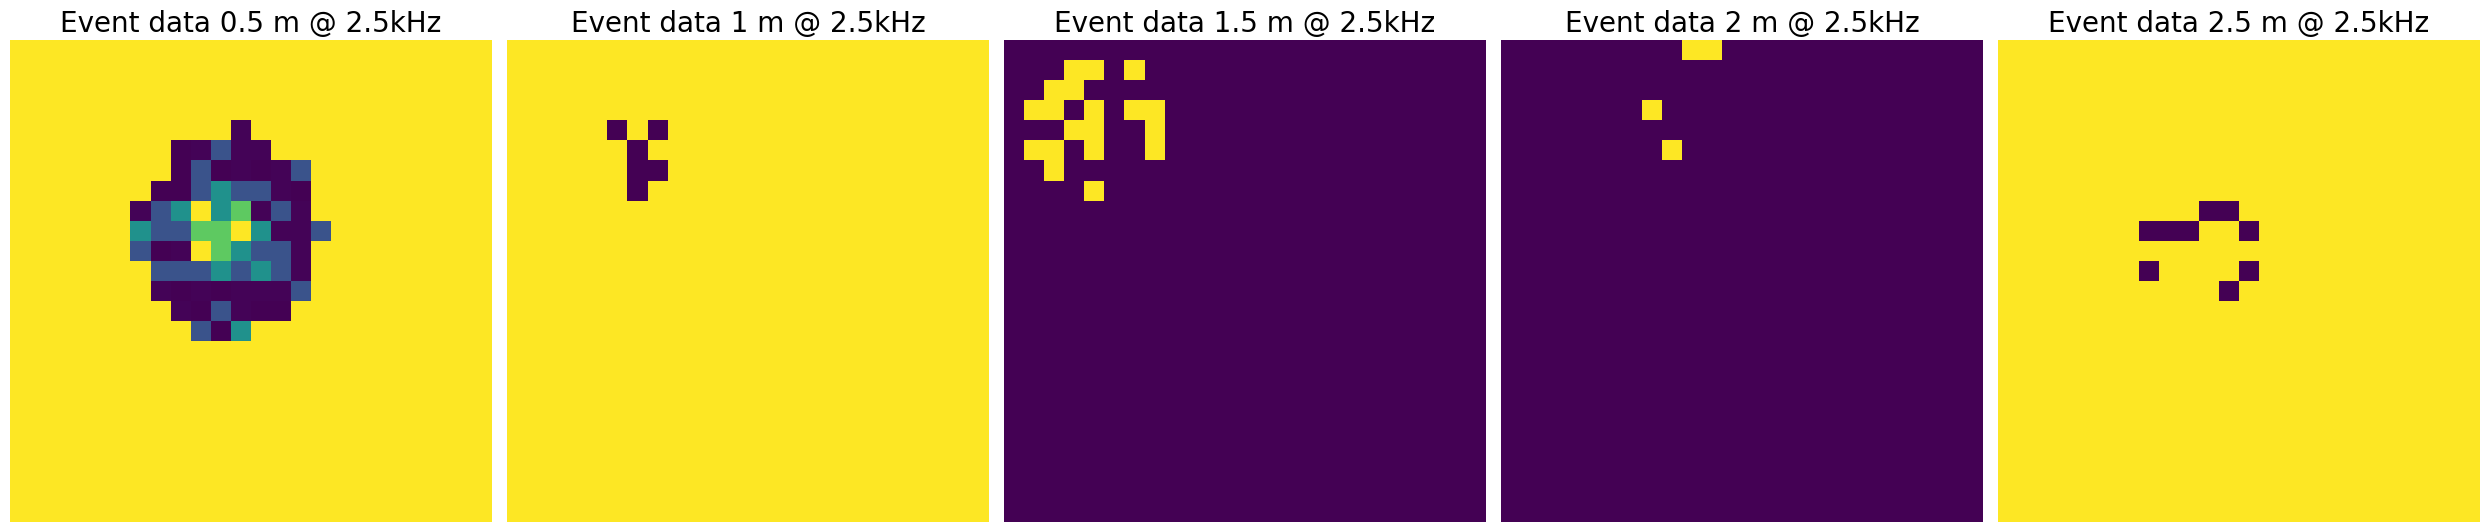

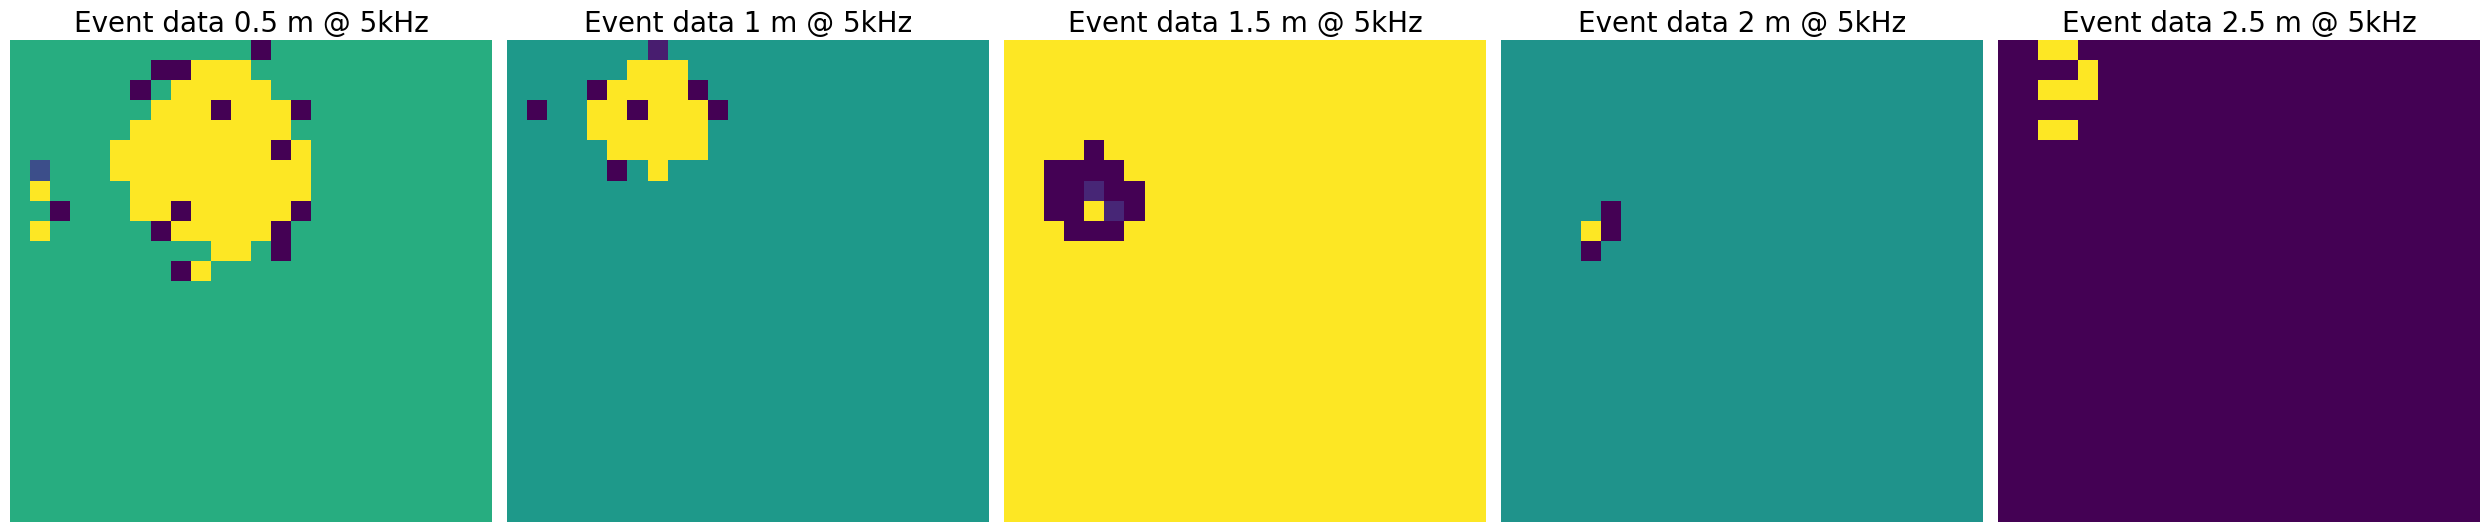

In [43]:
from util import filter_raws, move_events
from plotting import visualize_data_events

#bounding boxes need to be passed as an array
__f_2_5k = [(r, [bb_2_5k[i]]) for i, r in enumerate(raws_2_5k)]
__f_5k = [(r, [bb_5k[i]]) for i, r in enumerate(raws_5k)]

f_events_2_5k = filter_raws(__f_2_5k)
f_events_5k = filter_raws(__f_5k)

f_events_2_5k = [move_events(e) for e in f_events_2_5k]
f_events_5k = [move_events(e) for e in f_events_5k]

visualize_data_events(f_events_2_5k, lables_2_5k)
visualize_data_events(f_events_5k, lables_5k)

### Frequency analysis demo

In [44]:
from metavision_sdk_analytics import DominantFrequencyEventsAlgorithm

min_freq = 100
max_freq = 30000
freq_precision=10
min_count = 0

dominant_freq_algo = DominantFrequencyEventsAlgorithm(frequency_precision = freq_precision, min_frequency = min_freq, max_frequency = max_freq, min_count = min_count)

r = raws_5k[0]
r.reset()
evs = r.load_n_events(150000)

# print(evs.shape)
# print(evs.dtype)

print(f"Frequency: {dominant_freq_algo.compute_dominant_value(evs)[1]} Hz")


Frequency: 24220.0 Hz


### Analyze the LEDs

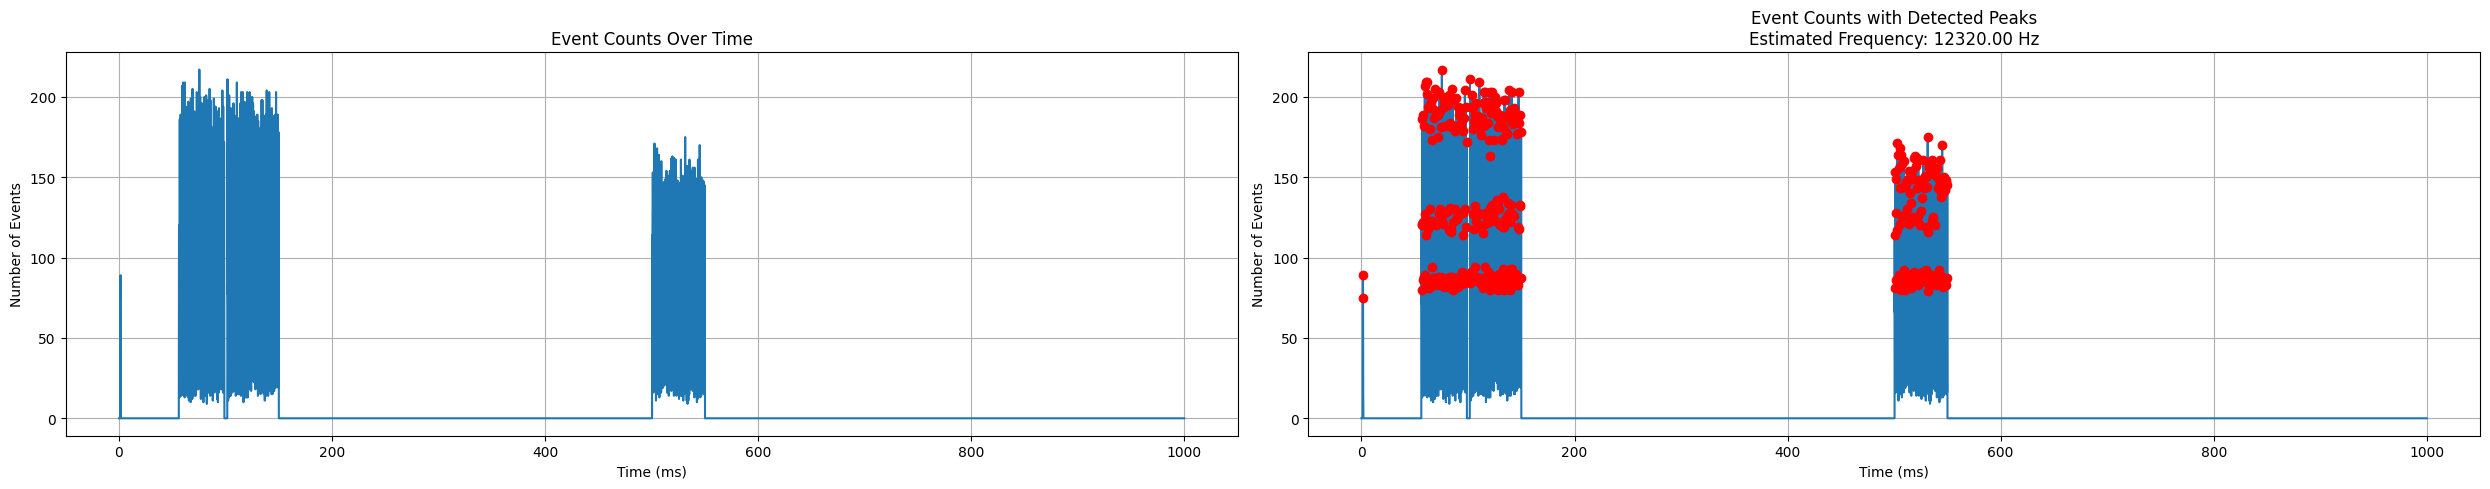

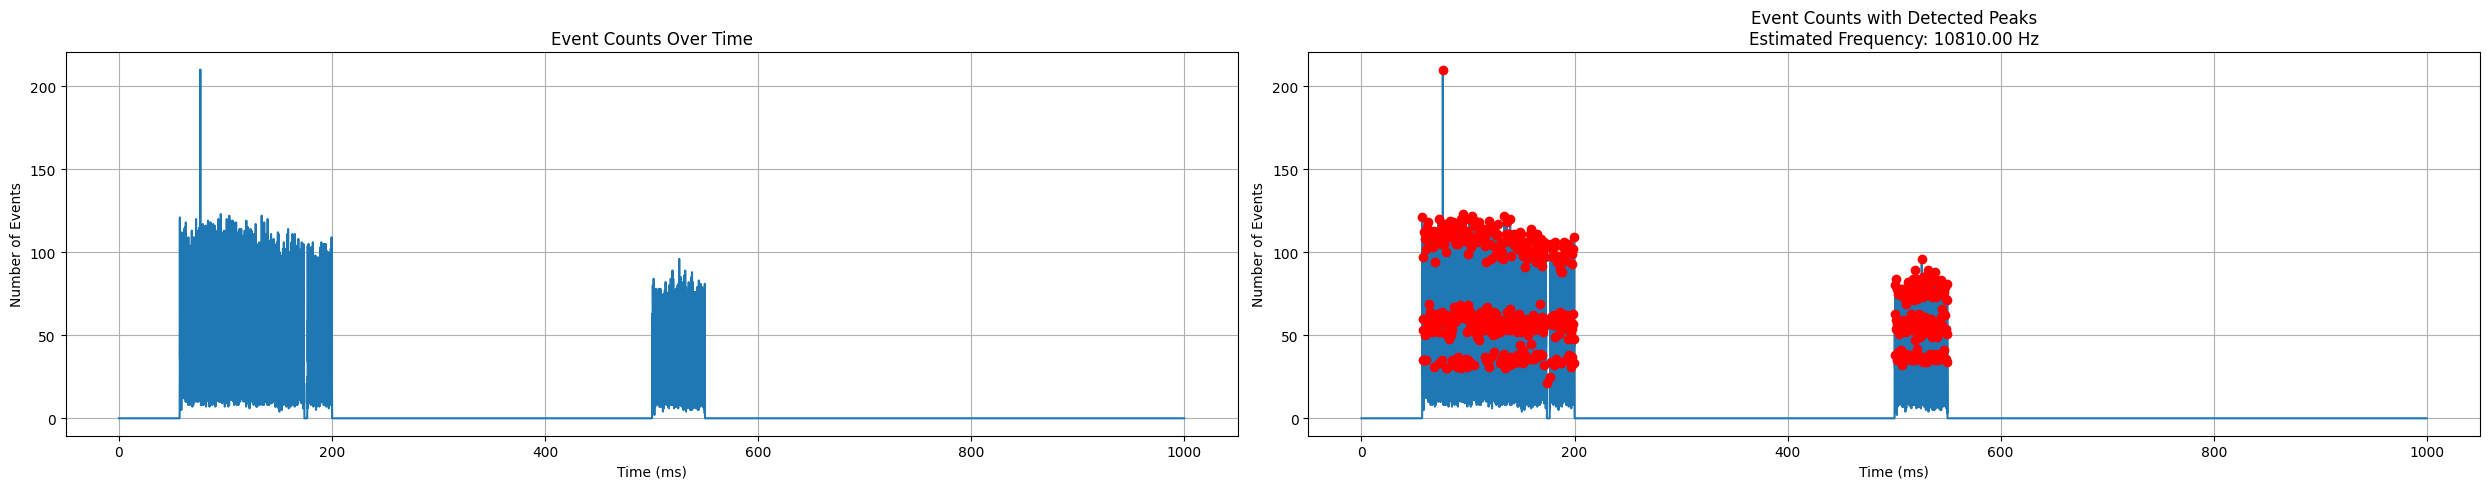

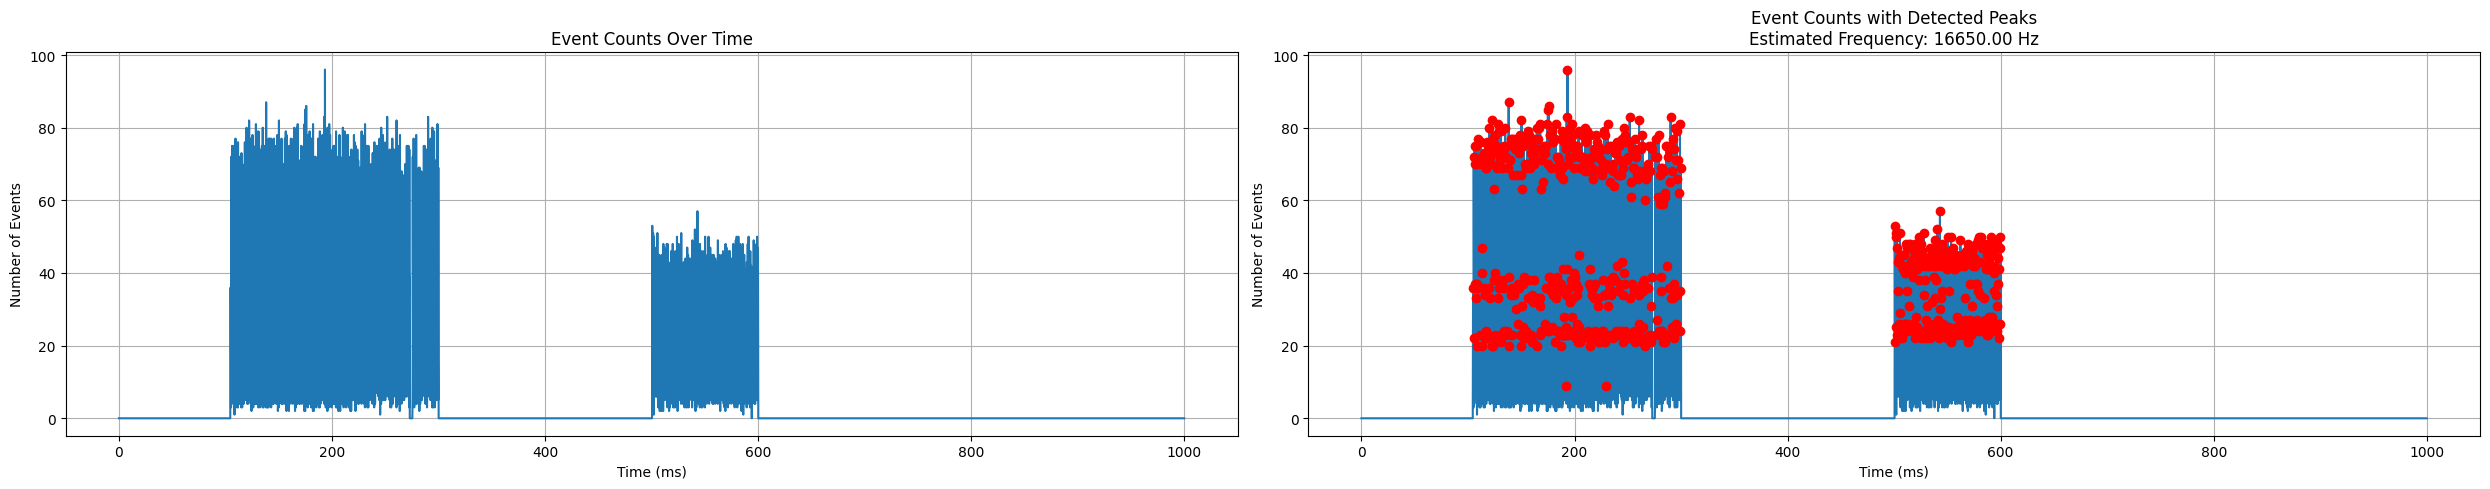

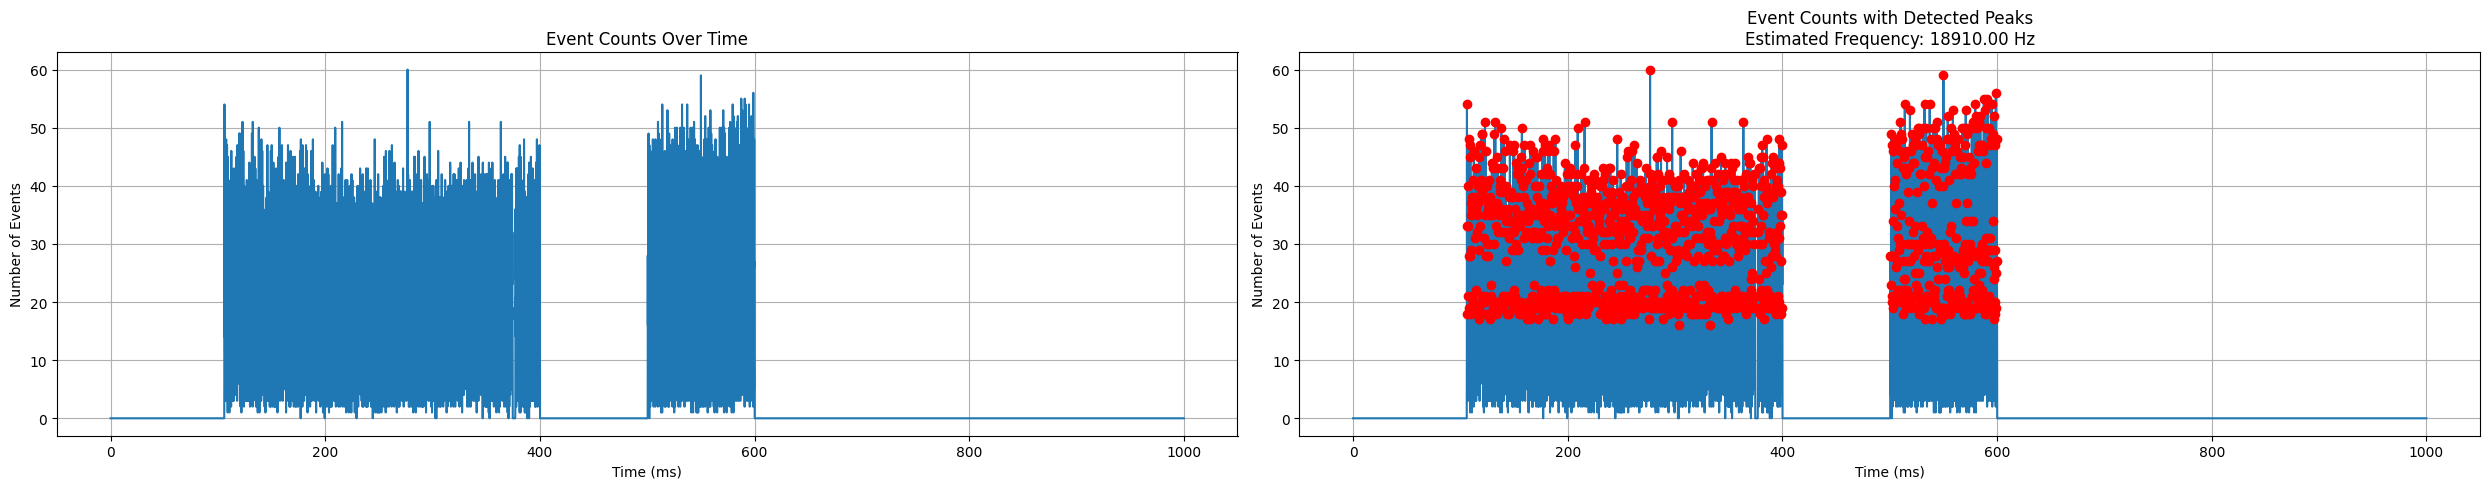

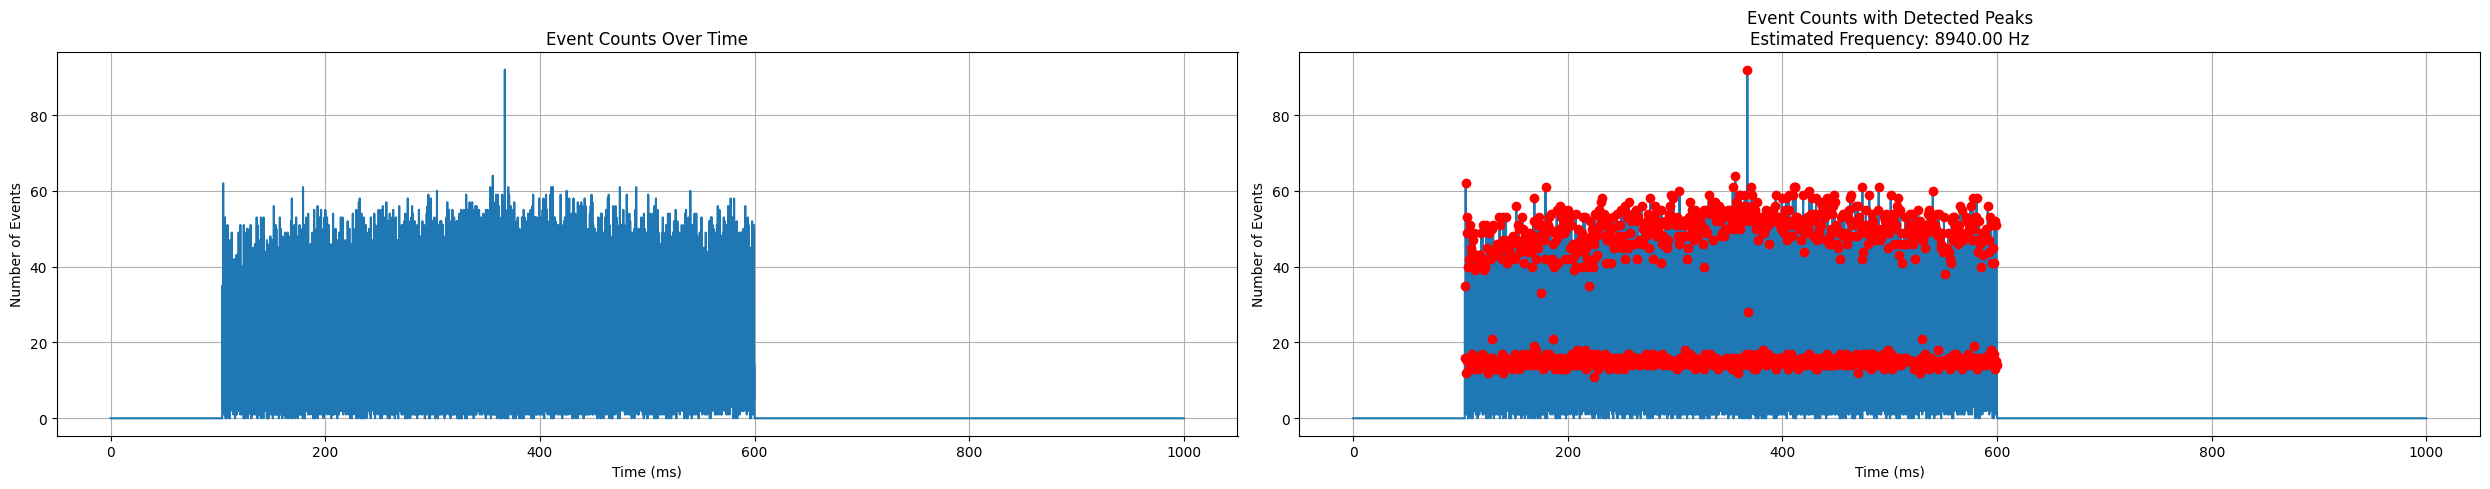

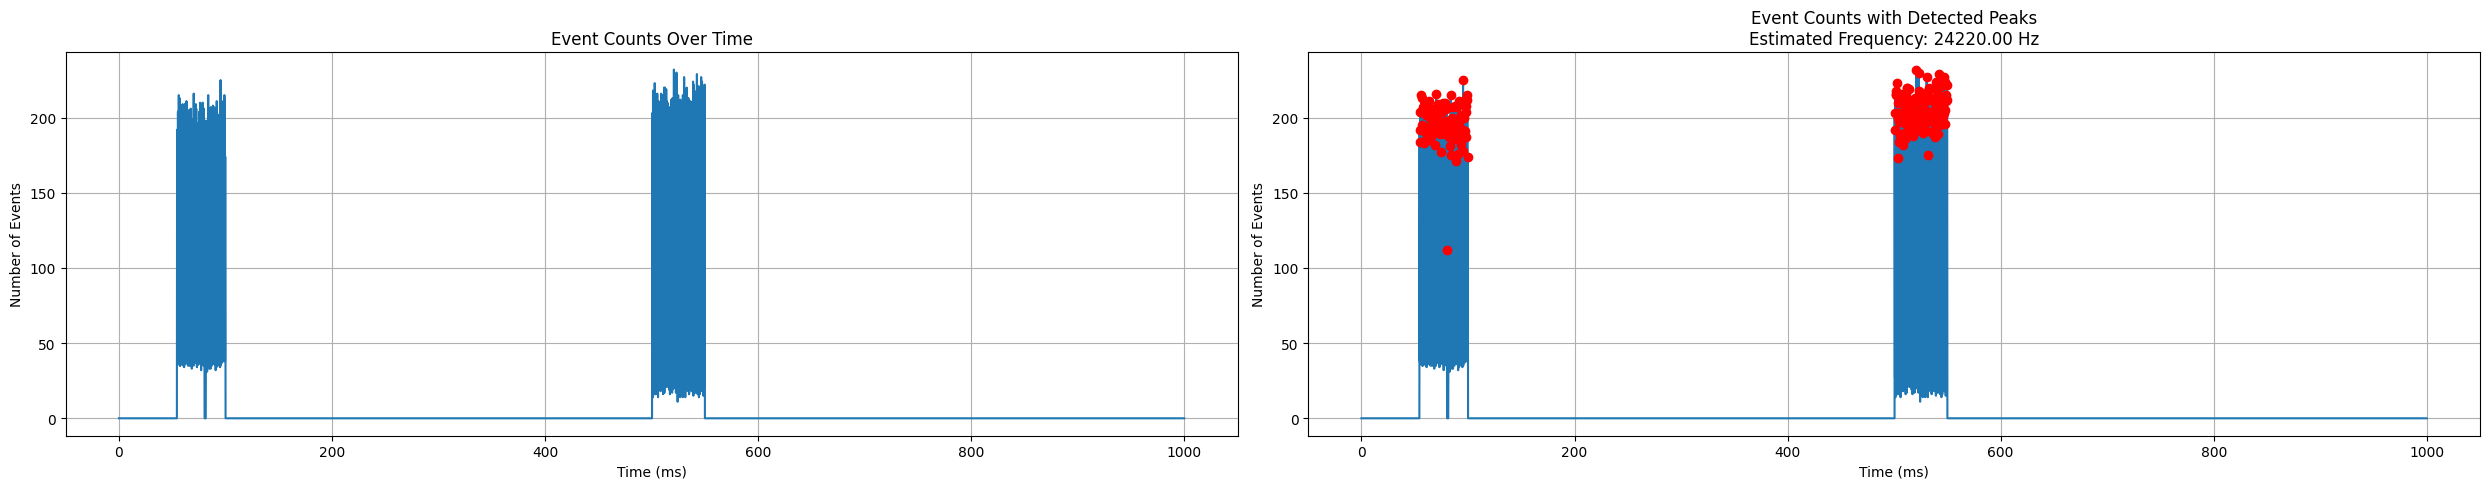

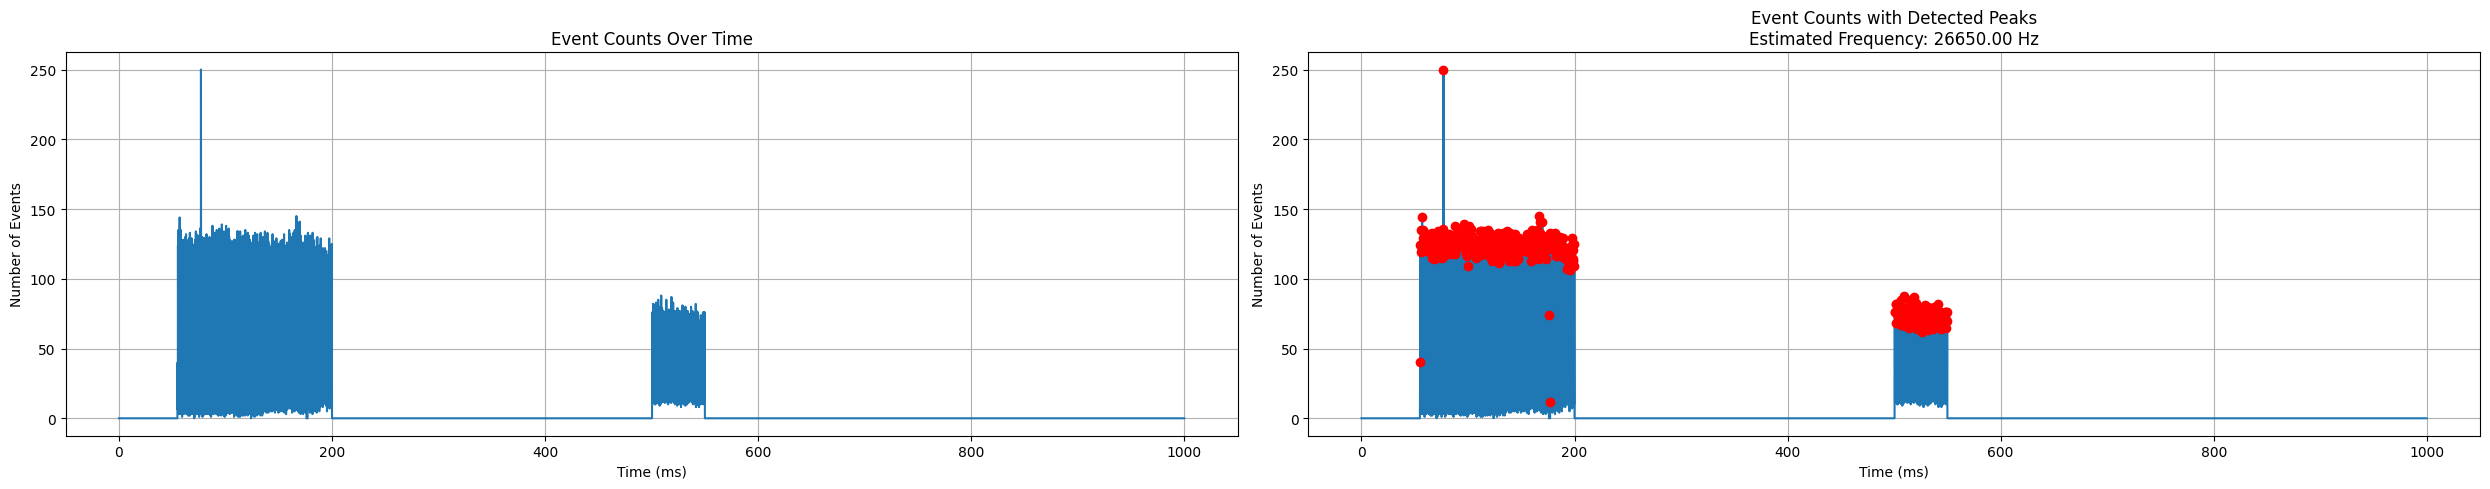

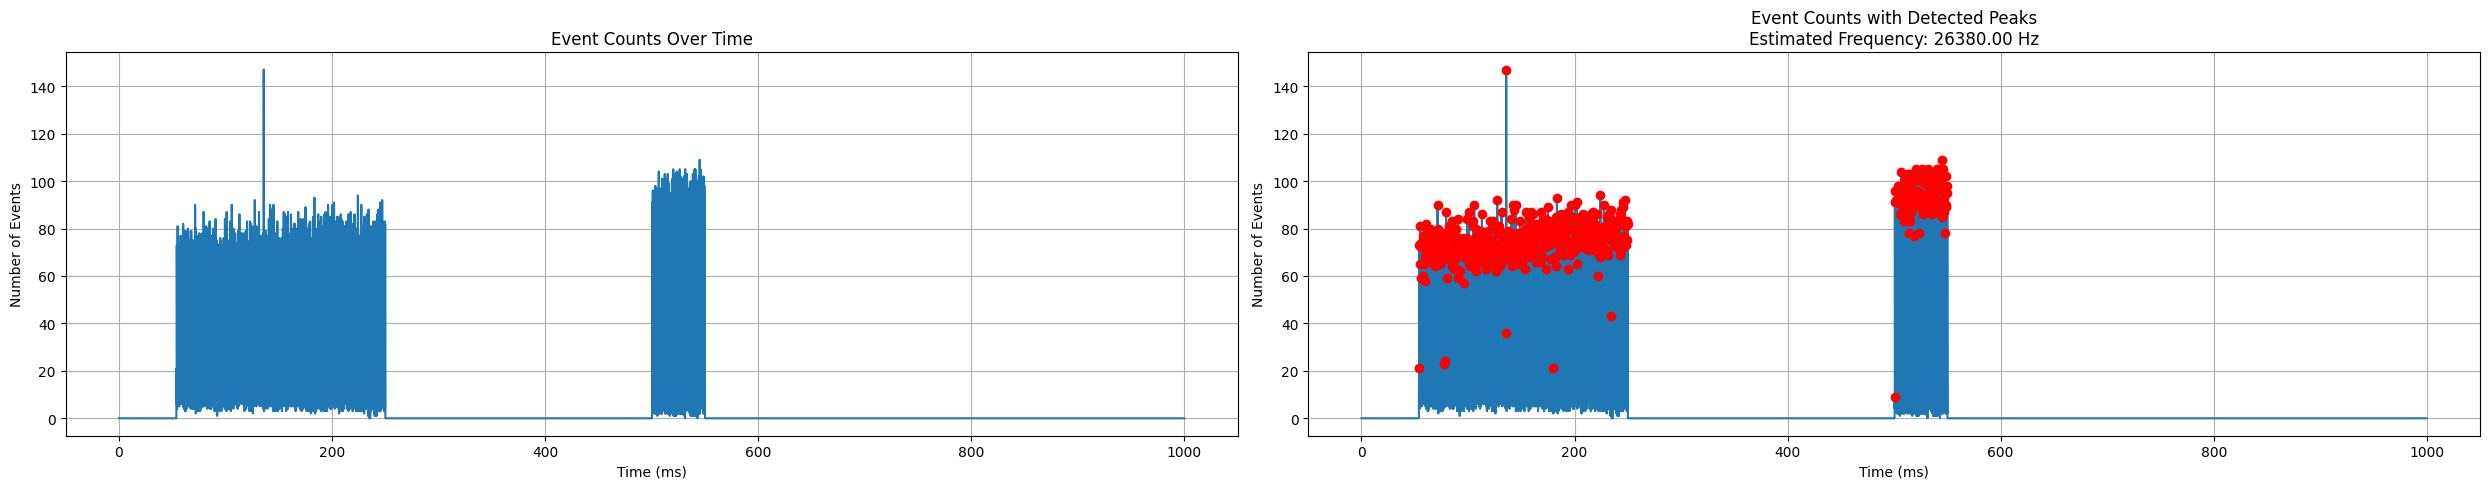

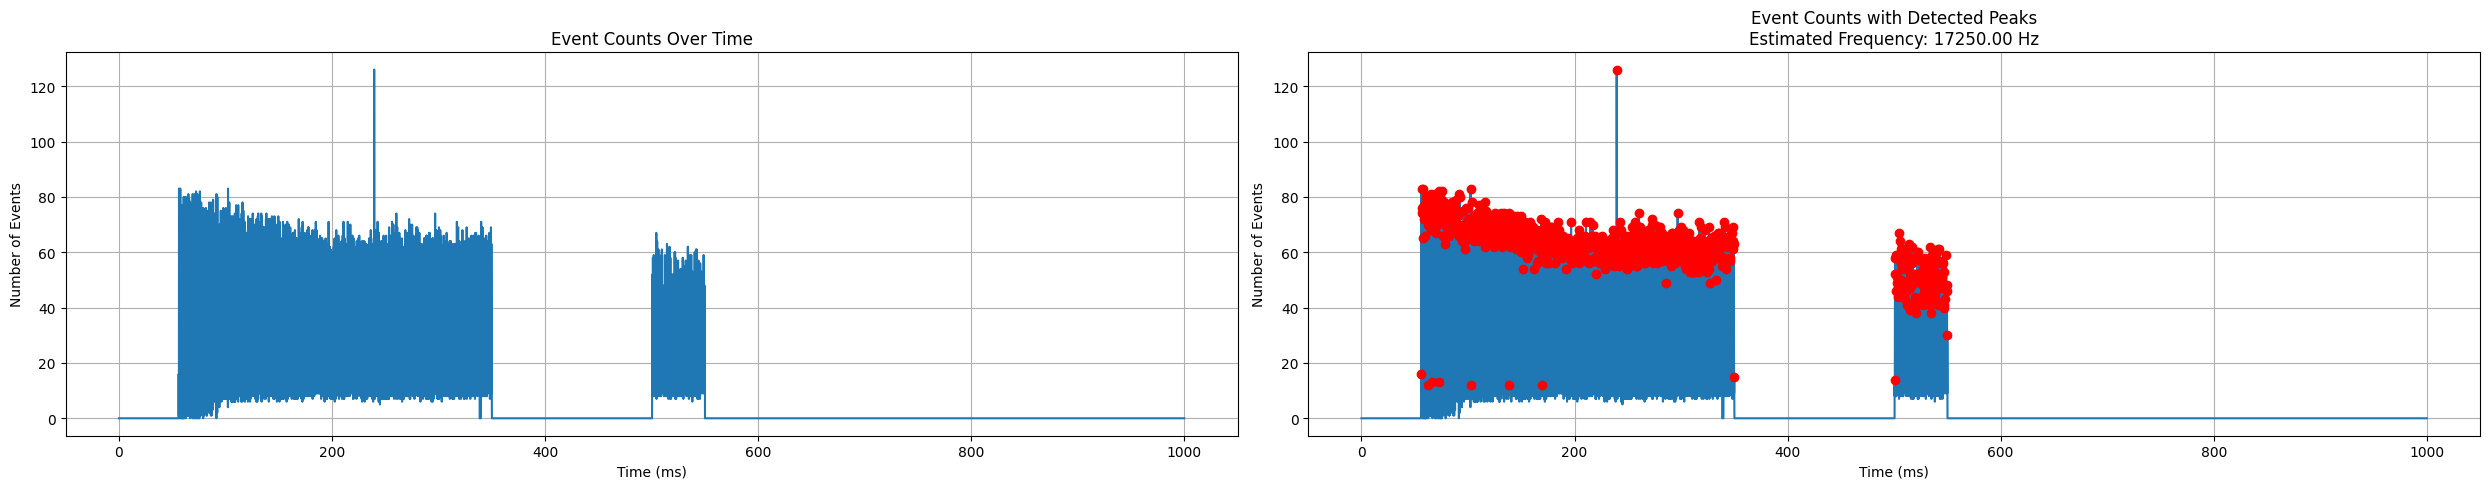

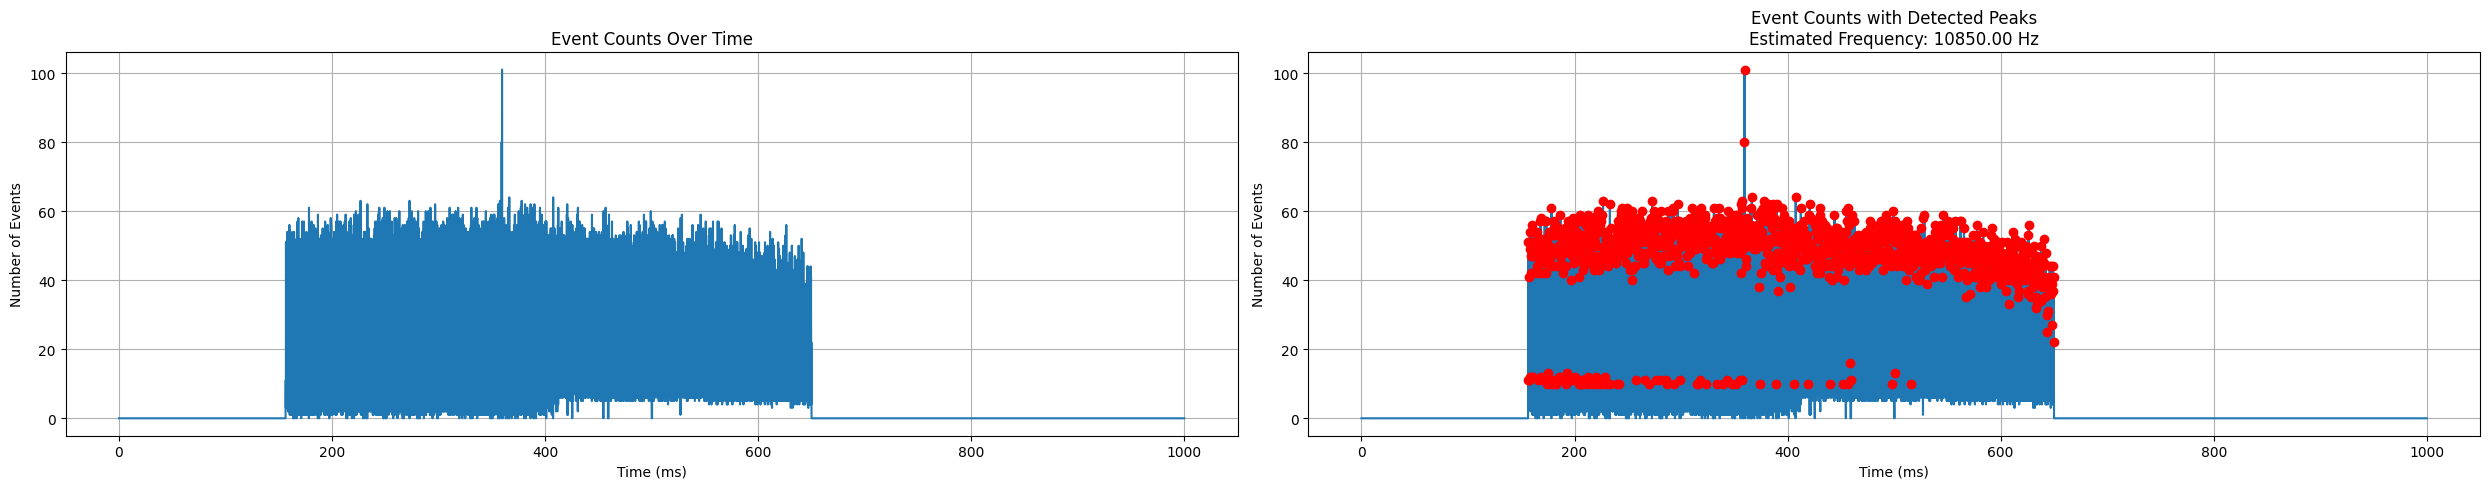

In [45]:
from plotting import create_combined_plot
from util import cut_timelt_events, estimate_frequency_from_raw

cut_time = 1000 #in us

f_events_2_5k = [cut_timelt_events(x, cut_time) for x in f_events_2_5k]
f_events_5k = [cut_timelt_events(x, cut_time) for x in f_events_5k]

dominant_freq_algo.compute_dominant_value(f_events_2_5k[0])

freqs_2_5k = [estimate_frequency_from_raw(r, num_events=150000) for r in raws_2_5k]
freqs_5k = [estimate_frequency_from_raw(r, num_events=150000) for r in raws_5k]

for (x, f) in zip(f_events_2_5k, freqs_2_5k):
	create_combined_plot(x, f)

for (x, f) in zip(f_events_5k, freqs_5k):
	create_combined_plot(x, f)